# Quantum Feature Maps and Kernels

Below are notes from each section of the qiskit course documentation found on this page: https://learn.qiskit.org/course/machine-learning/quantum-feature-maps-kernels

## Introduction

Many machine learning algorithms map input datasets to higher dimensional feature spaces through the use of a kernel function:

$k(\vec{x_i}, \vec{x_j}) = <f(\vec{x_i}), f(\vec{x_j})>$

where k is the kernel function, $\vec{x_i}, \vec{x_j}$ are n dimensional inputs, f is a map from n-dimension to m-dimension space, and $<a, b>$ denotes the dot product. We can represent the kernel function as an n x n matrix where the element in the ith row and jth column is the kernel function for the ith datapoint and jth datapoint.

We can visualize the concept of mapping to a higher dimension with the dataset shown below, which is not linearly separable in 2-dimensions.

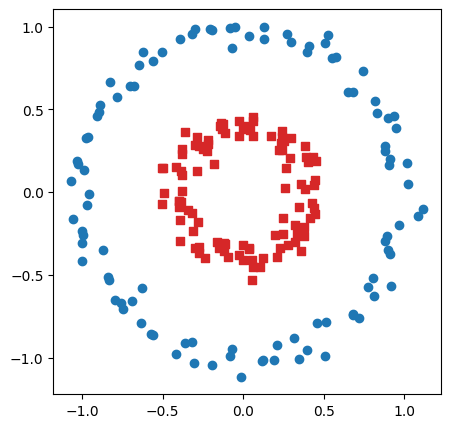

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pylab as pl
from sklearn.datasets import make_circles

# Create circles dataset
X, Y = make_circles(n_samples=200, noise=0.05, factor=0.4)

# Separate smaller and larger circles
A = X[np.where(Y==0)]
B = X[np.where(Y==1)]

# Plot in 2D
plt.figure(figsize=(5,5))
plt.scatter(A[:,0],A[:,1], marker='o')
plt.scatter(B[:,0],B[:,1], marker='s', c='C3')
plt.show()

However, when we map it to 3 dimensions being the original x, y, and the newly added x^2 + y^2 feature, it does become separable by a plane.

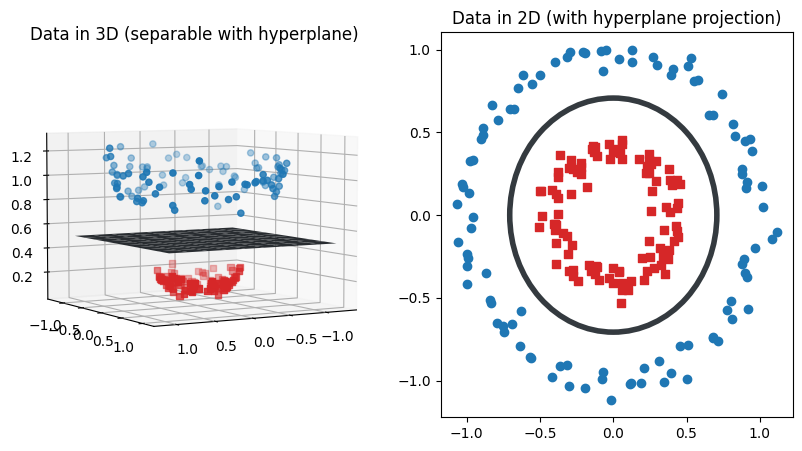

In [2]:
def transform_function(x, y):
    """ Implements f(x,y) = [x, y, z = x^2 + y^2] """
    return np.array([x, y, x**2.0 + y**2.0])

# Transform
A1 = np.array([transform_function(x, y) for
               x, y in zip(np.ravel(A[:,0]), np.ravel(A[:,1]))])
B1 = np.array([transform_function(x, y)
               for x, y in zip(np.ravel(B[:,0]), np.ravel(B[:,1]))])

# Plot in 3D
fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(121, projection='3d')
ax.set_title("Data in 3D (separable with hyperplane)")
ax.scatter(A1[:,0], A1[:,1], A1[:,2], marker='o')
ax.scatter(B1[:,0], B1[:,1], B1[:,2], marker='s', c='C3')  # make red
ax.view_init(5, 60)
x = np.arange(-1.25, 1.25, 0.25)
y = np.arange(-1.25, 1.25, 0.26)
X, Y = np.meshgrid(x, y)
Z = np.zeros(X.shape)
Z[:,:] = 0.5
ax.plot_surface(X, Y, Z, color='#343A3F')

# Project data to 2D
ax2d = fig.add_subplot(122)
ax2d.set_title("Data in 2D (with hyperplane projection)")
ax2d.scatter(A1[:,0], A1[:,1], marker='o')
ax2d.scatter(B1[:,0], B1[:,1], marker='s',
            c='C3')  # make red
ax2d.add_patch(pl.Circle((0,0), radius=np.sqrt(0.5),
               fill=False, linestyle='solid', linewidth=4.0,
               color='#343A3F'))
plt.show()

## Quantum feature maps

In QML, a quantum feature map, $\phi(\vec{x})$, maps a classical feature vector $\vec{x}$ to a quantum Hilbert space $\ket{\phi(\vec{x})}\bra{\phi(\vec{x})}$. This transformation is done using a unitary operator on a parameterized quantum circuit.

Quantum feature maps based on parameterized quantum circuits need to be hard to simulate classically in order to have the possibility of achieving a quantum advantage. One set of proposed quantum feature maps can be implemented using Qiskit's PauliFeatureMap which contains layers of Hadamard gates and entangling blocks.

We can test this out on some data. First, lets get the adhoc dataset in Qiskit which is a two class dataset sampled from the ZZFeatureMap. This will have 40 training points and 10 test points which half from one class and the other half from the other class.

In [3]:
from qiskit.utils import algorithm_globals
algorithm_globals.random_seed = 12345

from qiskit_machine_learning.datasets import ad_hoc_data
train_data, train_labels, test_data, test_labels, sample_total = (
    ad_hoc_data(training_size=20, test_size=5, n=2, gap=0.3,
                include_sample_total=True, one_hot=False))

We can now plot our data. In the far left plot are the 40 sampled datapoints, the middle plot shows the actual class boundaries, and the right plot just puts those two plots into one. We can see how complicated the class boundary is.

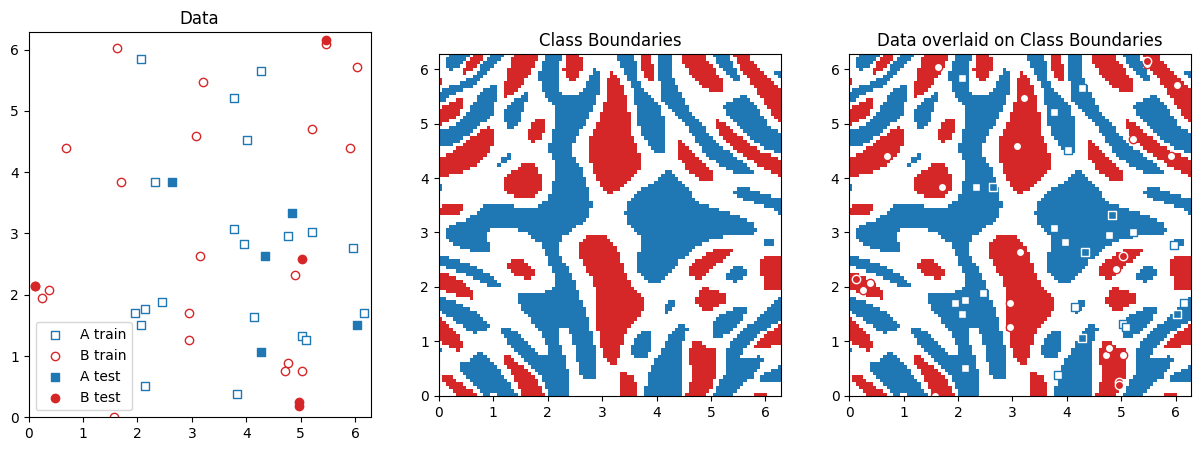

In [4]:
# Plot data and class boundaries
fig = plt.figure(figsize=(15, 5))
axdata = fig.add_subplot(131)
axdata.set_title("Data")
axdata.set_ylim(0, 2 * np.pi)
axdata.set_xlim(0, 2 * np.pi)
plt.scatter(train_data[np.where(train_labels[:] == 0), 0],
            train_data[np.where(train_labels[:] == 0), 1],
            marker='s', facecolors='w', edgecolors='C0',
            label="A train")
plt.scatter(train_data[np.where(train_labels[:] == 1), 0],
            train_data[np.where(train_labels[:] == 1), 1],
            marker='o', facecolors='w', edgecolors='C3',
            label="B train")
plt.scatter(test_data[np.where(test_labels[:] == 0), 0],
            test_data[np.where(test_labels[:] == 0), 1],
            marker='s', facecolors='C0', label="A test")
plt.scatter(test_data[np.where(test_labels[:] == 1), 0],
            test_data[np.where(test_labels[:] == 1), 1],
            marker='o', facecolors='C3', label="B test")
plt.legend()

from matplotlib.colors import ListedColormap
cmap = ListedColormap(["C3","w","C0"])
axmap = fig.add_subplot(132)
axmap.set_title("Class Boundaries")
axmap.set_ylim(0, 2 * np.pi)
axmap.set_xlim(0, 2 * np.pi)
axmap.imshow(np.asmatrix(sample_total).T,
             interpolation='nearest',
             origin='lower', cmap=cmap,
             extent=[0, 2 * np.pi, 0, 2 * np.pi])
axboth = fig.add_subplot(133)
axboth.set_title("Data overlaid on Class Boundaries")
axboth.set_ylim(0, 2 * np.pi)
axboth.set_xlim(0, 2 * np.pi)
axboth.imshow(np.asmatrix(sample_total).T, interpolation='nearest',
              origin='lower', cmap=cmap,
              extent=[0, 2 * np.pi, 0, 2 * np.pi])
axboth.scatter(train_data[np.where(train_labels[:] == 0), 0],
               train_data[np.where(train_labels[:] == 0), 1],
               marker='s', facecolors='w', edgecolors='C0', label="A")
axboth.scatter(train_data[np.where(train_labels[:] == 1), 0],
               train_data[np.where(train_labels[:] == 1), 1],
               marker='o', facecolors='w', edgecolors='C3', label="B")
axboth.scatter(test_data[np.where(test_labels[:] == 0), 0],
               test_data[np.where(test_labels[:] == 0), 1],
               marker='s', facecolors='C0', edgecolors='w',
               label="A test")
axboth.scatter(test_data[np.where(test_labels[:] == 1), 0],
               test_data[np.where(test_labels[:] == 1), 1],
               marker='o', facecolors='C3', edgecolors='w',
               label="B test")
plt.show()

## Quantum kernels

The quantum feature map very naturally gives rise to a quantum kernel because the dot product is a measure of similarity (which is what the kernel method does) and is something we can easily calculate as the transition amplitude between the ith and jth (encoded) data points:

$|\bra{\phi^{\dagger}(\vec{x_j})}\ket{\phi(\vec{x_j})}|^2 = |\bra{0^{\otimes n}}U^{\dagger}_{\phi(\vec{x_j})}U_{\phi(\vec{x_i})}\ket{0^{\otimes n}}|^2$

In other words, what this circuit does is start with the all 0's state and then it applies the unitary operator to encode the $x_i$ datapoint into the quantum Hilbert space. Then, it is going to _decode_ the quantum state (decode meaning run the encoding circuit backwards) but using the decoder unitary operator for the jth datapoint. Then, it measures the probability of the final state being back to the start of all 0's. Basically, if the encoding of one datapoint and decoding of another datapoint ends up back in the same spot, we can say that the two datapoints are pretty similar in the Hilbert space which will be reflected in the very high probability measurement / transition amplitude.

So the above is done for each pair of datapoints in the dataset. We can analytically calculate and plot the kernel matrix for the training data in the adhoc dataset created above.

/var/folders/f6/glc4hjkn44gg3qtb6mq_88kc0000gq/T/ipykernel_46682/1868348849.py:16: DeprecationWarning: The class ``qiskit.opflow.state_fns.circuit_state_fn.CircuitStateFn`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. For code migration guidelines, visit https://qisk.it/opflow_migration.
  x_circuits = opflow.CircuitStateFn(feature_map).bind_parameters(
/var/folders/f6/glc4hjkn44gg3qtb6mq_88kc0000gq/T/ipykernel_46682/1868348849.py:19: DeprecationWarning: The class ``qiskit.opflow.state_fns.circuit_state_fn.CircuitStateFn`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. For code migration guidelines, visit https://qisk.it/opflow_migration.
  y_circuits = opflow.CircuitStateFn(feature_map).bind_parameters(


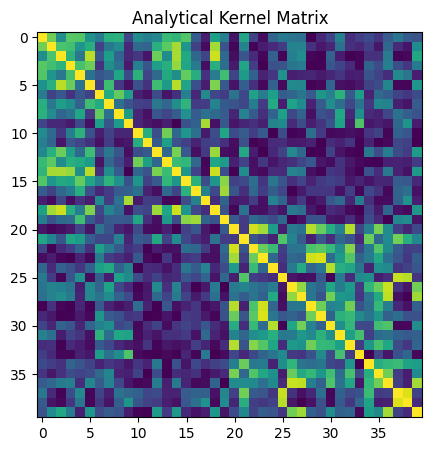

In [7]:
from qiskit.circuit.library import ZZFeatureMap

from qiskit import opflow
def calculate_kernel(feature_map, x_data, y_data=None):
    """
        Calculates  kernel matrix from provided feature map and
        dataset(s), x & (y). If y isn't given, self inner product
        of x is calculated.
        No error checking is performed, feature map and datasets
        assumed to have the same dimension
    """
    if y_data is None:
        y_data = x_data
    # Use Operator Flow to create a list of feature map circuits,
    # parameterized by each data point
    x_circuits = opflow.CircuitStateFn(feature_map).bind_parameters(
        dict(zip(feature_map.parameters, np.transpose(x_data).tolist()))
        )
    y_circuits = opflow.CircuitStateFn(feature_map).bind_parameters(
        dict(zip(feature_map.parameters, np.transpose(y_data).tolist()))
        )
    # Compute the square of the conjugate inner product of the feature
    # map circuits: the kernel matrix
    kernel = np.abs(
        (~y_circuits.to_matrix_op() @ x_circuits.to_matrix_op()).eval()
    )**2
    return kernel

adhoc_feature_map = ZZFeatureMap(feature_dimension=2, reps=2)
kernel = calculate_kernel(adhoc_feature_map, train_data)
plt.figure(figsize=(5, 5))
plt.imshow(np.asmatrix(kernel),interpolation='nearest', origin='upper')
plt.title("Analytical Kernel Matrix")
plt.show()

## Quantum support vector classification

So being able to figure out the similarity of two datapoints in a higher dimension sounds cool but what is the point? Well in ML, and especially support vector machines, this quantity comes up often. We could always compute the value of the datapoint projected in that higher dimension and then take the dot product of the high-dimensional datapoints, but that tends to get very computationally expensive for very high (or sometimes infinite) dimensions of data. Thus, a kernel method is essentially a shortcut as it gives us a function that takes in the two datapoints and can tell us what the dot product would be in that higher dimensional space. So when the kernel function is easy to compute and the dimensions are high, this is a great advantage. 

The quantum kernel support vector classification algorithm has 3 steps:

1. Build the train quantum kernel matrix by measuring the transition probability for each pair of datapoints in the training dataset
2. Build the test quantum kernel matrix by measuring the transition probability for each training data point and test point
3. Use the train and test quantum kernel matrices in a classical SVM classification algorithm (plug in the values to the classical algorithm essentially in order to find the support vectors and thus the hyperplane separating the two classes)

Let's do this on the adhoc dataset generated above. First, we can complete steps 1 and 2 above to get our training and testing quantum kernel matrices.

/var/folders/f6/glc4hjkn44gg3qtb6mq_88kc0000gq/T/ipykernel_46682/1868348849.py:16: DeprecationWarning: The class ``qiskit.opflow.state_fns.circuit_state_fn.CircuitStateFn`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. For code migration guidelines, visit https://qisk.it/opflow_migration.
  x_circuits = opflow.CircuitStateFn(feature_map).bind_parameters(
/var/folders/f6/glc4hjkn44gg3qtb6mq_88kc0000gq/T/ipykernel_46682/1868348849.py:19: DeprecationWarning: The class ``qiskit.opflow.state_fns.circuit_state_fn.CircuitStateFn`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. For code migration guidelines, visit https://qisk.it/opflow_migration.
  y_circuits = opflow.CircuitStateFn(feature_map).bind_parameters(


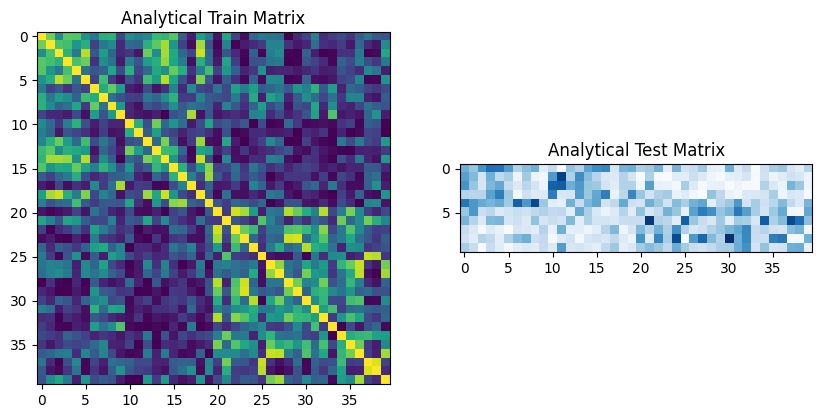

In [8]:
train_kernel = calculate_kernel(adhoc_feature_map, train_data)
test_kernel = calculate_kernel(adhoc_feature_map, train_data, test_data)
# plot analytical matrices
fig, axs = plt.subplots(1, 2, figsize=(10,5))
axs[0].imshow(np.asmatrix(train_kernel), interpolation='nearest',
              origin='upper')
axs[0].set_title("Analytical Train Matrix")
axs[1].imshow(np.asmatrix(test_kernel), interpolation='nearest',
              origin='upper', cmap='Blues')
axs[1].set_title("Analytical Test Matrix")
plt.show()

Now we can use these in scikit-learn svm algorithm (the classical part).

In [9]:
from sklearn.svm import SVC
# train scikit-learn svm model
model = SVC(kernel='precomputed')
model.fit(train_kernel, train_labels)
print("Number of support vectors for each class:",model.n_support_)
print("Indices of support vectors:", model.support_)

Number of support vectors for each class: [ 9 10]
Indices of support vectors: [ 3  6  7  8  9 11 12 17 19 21 22 24 25 26 27 31 33 38 39]


Below are the support vectors that were identified for each class, ie the nearest datapoints to the separating hyperplane.

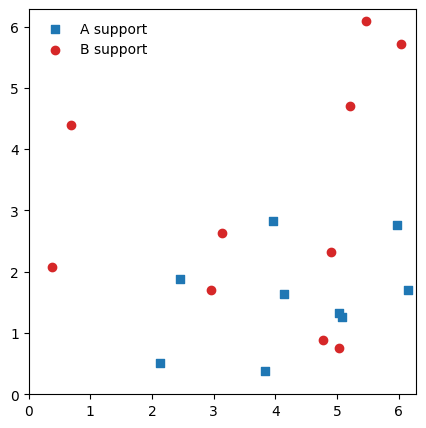

In [10]:
# Plot support vectors
plt.figure(figsize=(5, 5))
plt.ylim(0, 2 * np.pi)
plt.xlim(0, 2 * np.pi)
plt.scatter(train_data[model.support_[0:model.n_support_[0] ], 0],
            train_data[model.support_[0:model.n_support_[0] ], 1],
            marker='s', label="A support")
plt.scatter(train_data[model.support_[model.n_support_[0]:], 0],
            train_data[model.support_[model.n_support_[0]:], 1],
            marker='o', c='C3', label="B support")
plt.legend(loc='upper left', frameon=False)
plt.show()

In [11]:
# test svm model
model.score(test_kernel, test_labels)

1.0

### Qiskit implementation

There's also an out-of-the-box implementation that Qiskit offers which code for can be seen below.

In [14]:
from qiskit import BasicAer
from qiskit_machine_learning.kernels import QuantumKernel
# Create the quantum feature map
adhoc_feature_map = ZZFeatureMap(feature_dimension=2,
                                 reps=2,
                                 entanglement='linear')
# Create the quantum kernel
adhoc_kernel = QuantumKernel(feature_map=adhoc_feature_map,
                             quantum_instance=BasicAer.get_backend(
                                             'statevector_simulator'))

# Set the SVC algorithm to use our custom kernel
adhoc_svc = SVC(kernel=adhoc_kernel.evaluate)
adhoc_svc.fit(train_data, train_labels)
adhoc_svc.score(test_data, test_labels)

1.0

## Quantum kernel alignment

All the feature maps shown here haven't contained any trainable parameters; they are parameterized circuit whose parameters are all defined by the data being encoded. Quantum feature maps can also have variational parameters though that can be optimized in a technique called kernel alignment. This is analogous to kernel alignment in classical machine learning.

## Quantum kernel machine learning

Quantum kernel methods provide a way to use quantum computers in machine learning. The most prevalent quantum kernel algorithm is the quantum kernel support vector (QKSVM) which was introduced in 2019. Quantum kernels can also be used for clustering.